In [40]:
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import *

from scipy.stats import qmc

c = 3e8 # Speed of Light

class Muon:
    def __init__(self, x, y, z, v, v_theta, v_phi, lifetime):
        self.v_theta = v_theta
        self.v_phi = v_phi
        self.z_list = [z]
        self.v = v
        self.x_list = [x]
        self.y_list = [y]
        self.lifetime = lifetime

    def propagate(self, time_step):
        time = 0
        while time < self.lifetime and self.z_list[-1] > 0 and np.sqrt(self.x_list[-1]**2 + self.y_list[-1]**2) < 2:
            self.x_list.append(self.x_list[-1] + self.v * time * np.sin(self.v_phi) * np.cos(self.v_theta))
            self.y_list.append(self.y_list[-1] + self.v * time * np.sin(self.v_phi) * np.sin(self.v_theta))
            self.z_list.append(self.z_list[-1] - self.v * time * np.cos(self.v_phi))
            time += time_step

    def draw_path(self):
        return self.x_list, self.y_list, self.z_list

# Defines 3D regions where scintillation occurs.
class Scintillator:
    def __init__(self, radius, floor, ceiling):
        self.r = radius
        # Position in the z-axis of the bottom and top of the scintillator.
        self.floor = floor
        self.ceiling = ceiling

    def has_muon(self, muon):
        for i in range(muon.z_list):
            if self.floor <= muon.z_list[i] <= self.ceiling and np.sqrt(muon.x_list**2 + muon.y_list**2) <= self.r:
                return True
        return False

    def draw_scintillator(self):
        z = np.linspace(self.floor,self.ceiling, 50)
        theta = np.linspace(0, 2 * np.pi, 50)
        z_grid, theta_grid = np.meshgrid(z, theta)
        x_grid = self.r * np.cos(theta_grid)
        y_grid = self.r * np.sin(theta_grid)
        return x_grid, y_grid, z_grid


In [48]:
# returns random velocities to be used to build a muon class
def random_velocities(number):
    sampler = qmc.LatinHypercube(d = 1)
    sample = sampler.random(n = number)
    velocities = qmc.scale(sample,  0.9990, 0.9995)
    velocities *= c
    return velocities

def random_theta(number):
    sampler = qmc.LatinHypercube(d = 1)
    sample = sampler.random(n = number)
    thetas = qmc.scale(sample,  0, 2 * np.pi)
    return thetas

def random_phi(number):
    sampler = qmc.LatinHypercube(d = 1)
    sample = sampler.random(n = number)
    phis = qmc.scale(sample,  0, np.pi/4)
    return phis

def random_r(number):
    sampler = qmc.LatinHypercube(d = 1)
    sample = sampler.random(n = number) * 0.2
    return sample

def random_lifetime(number):
    sample = np.random.exponential(2.2e-6, number)
    # histogram demonstrates the expected distribution for a half-life count
    # plt.hist(sample)
    return sample

def random_muons(samples):
    rand_r = random_r(samples)
    rand_theta = random_theta(samples)
    rand_x = rand_r * np.sin(rand_theta)
    rand_y = rand_r * np.cos(rand_theta)
    rand_v = random_velocities(samples)
    rand_v_theta = random_theta(samples)
    rand_v_phi = random_phi(samples)
    rand_lifetime = random_lifetime(samples)
    muon_list = []
    for i in range(samples):
        muon_list.append(Muon(rand_x[i], rand_y[i], 0.6, rand_v[i], rand_v_theta[i], rand_v_phi[i], rand_lifetime[i]))
    return muon_list

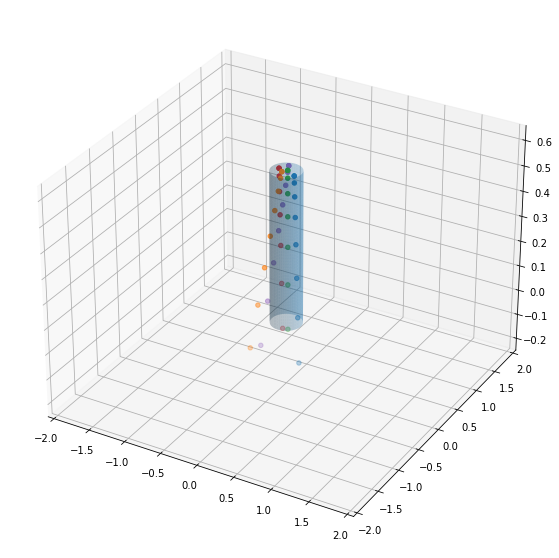

In [56]:
muons = random_muons(5)
experiment = Scintillator(0.2, 0, 0.6)

for muon in muons:
    muon.propagate(1e-10)

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection ="3d")
x, y, z = experiment.draw_scintillator()
ax.plot_surface(x, y, z, alpha = 0.3)
for muon in muons:
    line_x, line_y, line_z = muon.draw_path()
    x = [float(i) for i in line_x]
    y = [float(i) for i in line_y]
    z = [float(i) for i in line_z]
    ax.scatter(x, y, z)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
fig.set_figwidth(10)
fig.set_figheight(10)
plt.savefig('experiment.png')
